# 🎰 Análisis de Datos Históricos de Lotería

## 📋 Descripción del Proyecto

Este proyecto tiene como objetivo extraer, procesar y analizar datos históricos de sorteos de lotería a partir de archivos PDF oficiales. Utilizando técnicas de procesamiento de texto y análisis de datos, transformamos documentos no estructurados en datos estructurados listos para su análisis.

### 🎯 Objetivos
- Extraer automáticamente números premiados y premios de PDFs oficiales
- Identificar patrones en los números ganadores a lo largo de los años
- Crear un dataset limpio y estructurado para análisis posteriores
- Generar visualizaciones que permitan identificar tendencias

### 🛠️ Tecnologías Utilizadas
- **PyMuPDF (fitz)**: Extracción de texto de documentos PDF
- **Pandas**: Manipulación y análisis de datos
- **Matplotlib & Seaborn**: Visualización de datos
- **Regex**: Procesamiento y validación de patrones de texto

---

## 📦 Importación de Librerías


In [ ]:
import fitz  # PyMuPDF
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from pathlib import Path
# Configuración de visualizaciones
%matplotlib inline

carpeta_pdfs = "pdfs_loteria"

---

## 🔍 Configuración Inicial y Carga de Archivos

In [37]:
# Buscar todos los PDFs dentro de la carpeta
archivos_pdf = list(Path(carpeta_pdfs).glob("*.pdf"))
print(f"Encontrados {len(archivos_pdf)} archivos📁 PDF\n")

Encontrados 12 archivos📁 PDF



---

## 🧩 Definición de Patrones de Extracción

Los PDFs contienen números y premios en diferentes formatos. Definimos patrones regex para identificarlos correctamente:

In [39]:
# Patrones (fuera del loop para eficiencia)
numero_grande_pattern = re.compile(r"^\d[\d.,]*$")
linea_valida_pattern = re.compile(r"^[\d\s.,\.\t]+$")

In [40]:
# Lista para acumular todos los datos
data_total = []

---

## 🔄 Procesamiento de PDFs y Extracción de Datos

Esta es la sección principal donde procesamos cada PDF y extraemos la información estructurada:

In [41]:
# Procesar cada PDF
for archivo_pdf in sorted(archivos_pdf):
    # Extraer año del nombre del archivo (ej: SM_LISTAOFICIAL.A2015.S102.pdf)
    nombre_archivo = archivo_pdf.name
    match = re.search(r'A(\d{4})', nombre_archivo)
    
    if not match:
        print(f"⚠️  Saltando {nombre_archivo} - no se pudo extraer el año")
        continue
    
    anno = int(match.group(1))
    print(f"📄 Procesando: {nombre_archivo} (Año {anno})...")
    
    # Abrir PDF
    doc = fitz.open(str(archivo_pdf))
    buffer_num = None
    resultado = []
    
    # Extraer texto del PDF
    for page in doc:
        blocks = page.get_text("dict")["blocks"]
        for block in blocks:
            if "lines" in block:
                for line in block["lines"]:
                    line_text = "".join(span["text"] for span in line["spans"]).strip()
                    
                    # saltar líneas vacías
                    if not line_text:
                        continue
                    
                    # Detectamos premio grande: línea solo con número
                    if line_text.isdigit():
                        buffer_num = line_text
                    
                    # Detectamos línea con premio y hay número en buffer
                    elif buffer_num and numero_grande_pattern.match(line_text):
                        # limpiar puntos y comas del premio
                        premio_num = line_text.replace('.', '').replace(',', '')
                        resultado.append(f"{buffer_num} .. t .. {premio_num}")
                        buffer_num = None
                    
                    # Solo agregar líneas que ÚNICAMENTE contengan números y separadores válidos
                    elif linea_valida_pattern.match(line_text):
                        resultado.append(line_text)
    
    doc.close()
    
    # Procesar las líneas extraídas de este PDF
    for linea in resultado:
        # Detectar si es premio especial (contiene ".. t ..")
        if ".. t .." in linea or "..t.." in linea:
            partes = re.split(r'\.\.\s*t\s*\.\.', linea)
            if len(partes) == 2:
                numero = partes[0].strip().replace('.', '').replace(',', '').replace(' ', '')
                premio = partes[1].strip().replace('.', '').replace(',', '').replace(' ', '')
                # Rellenar con ceros a la izquierda si es necesario
                numero = numero.zfill(5)
                data_total.append({
                    'anno': anno,
                    'numero': numero,
                    'premio': premio,
                    'tipo': 'especial'
                })
        else:
            # Extraer número y premio de líneas normales (ej: "17155. . . . . 1000")
            numeros = re.findall(r'\d+', linea)
            if len(numeros) >= 2:
                numero = numeros[0]
                premio = numeros[-1]
                # Rellenar con ceros a la izquierda para tener 5 dígitos
                numero = numero.zfill(5)
                
                # Validación: el número debe ser válido (00000-99999)
                # y el premio debe ser diferente del número
                if int(numero) <= 99999 and numero != premio:
                    data_total.append({
                        'anno': anno,
                        'numero': numero,
                        'premio': premio,
                        'tipo': 'normal'
                    })
            elif len(numeros) == 1:
                # Solo un número: puede ser un número premiado sin premio en la misma línea
                numero = numeros[0].zfill(5)  # Rellenar con ceros
                
                # Validar que sea un número de lotería válido (5 dígitos máximo)
                if int(numero) <= 99999:
                    data_total.append({
                        'anno': anno,
                        'numero': numero,
                        'premio': None,
                        'tipo': 'normal'
                    })

📄 Procesando: SM_LISTAOFICIAL.A2013.S102.pdf (Año 2013)...
📄 Procesando: SM_LISTAOFICIAL.A2014.S102.pdf (Año 2014)...
📄 Procesando: SM_LISTAOFICIAL.A2015.S102.pdf (Año 2015)...
📄 Procesando: SM_LISTAOFICIAL.A2016.S102.pdf (Año 2016)...
📄 Procesando: SM_LISTAOFICIAL.A2017.S102.pdf (Año 2017)...
📄 Procesando: SM_LISTAOFICIAL.A2018.S102.pdf (Año 2018)...
📄 Procesando: SM_LISTAOFICIAL.A2019.S102.pdf (Año 2019)...
📄 Procesando: SM_LISTAOFICIAL.A2020.S102.pdf (Año 2020)...
📄 Procesando: SM_LISTAOFICIAL.A2021.S102.pdf (Año 2021)...
📄 Procesando: SM_LISTAOFICIAL.A2022.S102.pdf (Año 2022)...
📄 Procesando: SM_LISTAOFICIAL.A2023.S102.pdf (Año 2023)...
📄 Procesando: SM_LISTAOFICIAL.A2024.S102.pdf (Año 2024)...


---

## 📊 Creación del DataFrame y Análisis Exploratorio

In [42]:
# Crear DataFrame único con todos los datos
df = pd.DataFrame(data_total)

In [43]:
df

,anno,numero,premio,tipo
0,2013,00020,1000,normal
1,2013,00219,1000,normal
2,2013,00324,1000,normal
3,2013,00330,1000,normal
4,2013,00461,1000,normal
...,...,...,...,...
21679,2024,99692,1000,normal
21680,2024,99710,1000,normal
21681,2024,99769,1000,normal
21682,2024,99864,1000,normal


---

### 🔍 Observación de la estructura del DataFrame

El siguiente bloque de código tiene como objetivo **explorar la estructura general del DataFrame `df`** para entender su contenido y organización.

In [44]:
#Observar estructura del dataframe

# Ver las primeras filas
print(df.head(10))
print("\n")

# Ver información del DataFrame
print(df.info())
print("\n")

# Ver la forma del DataFrame
print(f"Shape: {df.shape}")
print(f"Columnas: {df.columns.tolist()}")

   anno numero premio    tipo
0  2013  00020   1000  normal
1  2013  00219   1000  normal
2  2013  00324   1000  normal
3  2013  00330   1000  normal
4  2013  00461   1000  normal
5  2013  00464   1000  normal
6  2013  00685   1000  normal
7  2013  00720   1000  normal
8  2013  00780   1000  normal
9  2013  00877   1000  normal


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21684 entries, 0 to 21683
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   anno    21684 non-null  int64 
 1   numero  21684 non-null  object
 2   premio  21684 non-null  object
 3   tipo    21684 non-null  object
dtypes: int64(1), object(3)
memory usage: 677.8+ KB
None


Shape: (21684, 4)
Columnas: ['anno', 'numero', 'premio', 'tipo']


In [18]:
#Vamos a comprobar cual es el numero premiado más repetido, independientemente de cual sea su premio
df['numero'].value_counts()

numero
41131    4
51244    4
86713    4
21316    4
00219    4
        ..
98745    1
98691    1
98666    1
98594    1
98553    1
Name: count, Length: 19647, dtype: int64

---

### 🎯 Análisis de los números más repetidos

El siguiente bloque de código permite **identificar y visualizar los números de lotería que más veces han resultado premiados** en el conjunto de datos.

Total de números únicos: 19647
Máximo de veces que se repite un número: 4

Top 10 números más repetidos:
numero
21316    4
00219    4
41131    4
51244    4
86713    4
95315    3
59230    3
15869    3
52340    3
48799    3
Name: count, dtype: int64


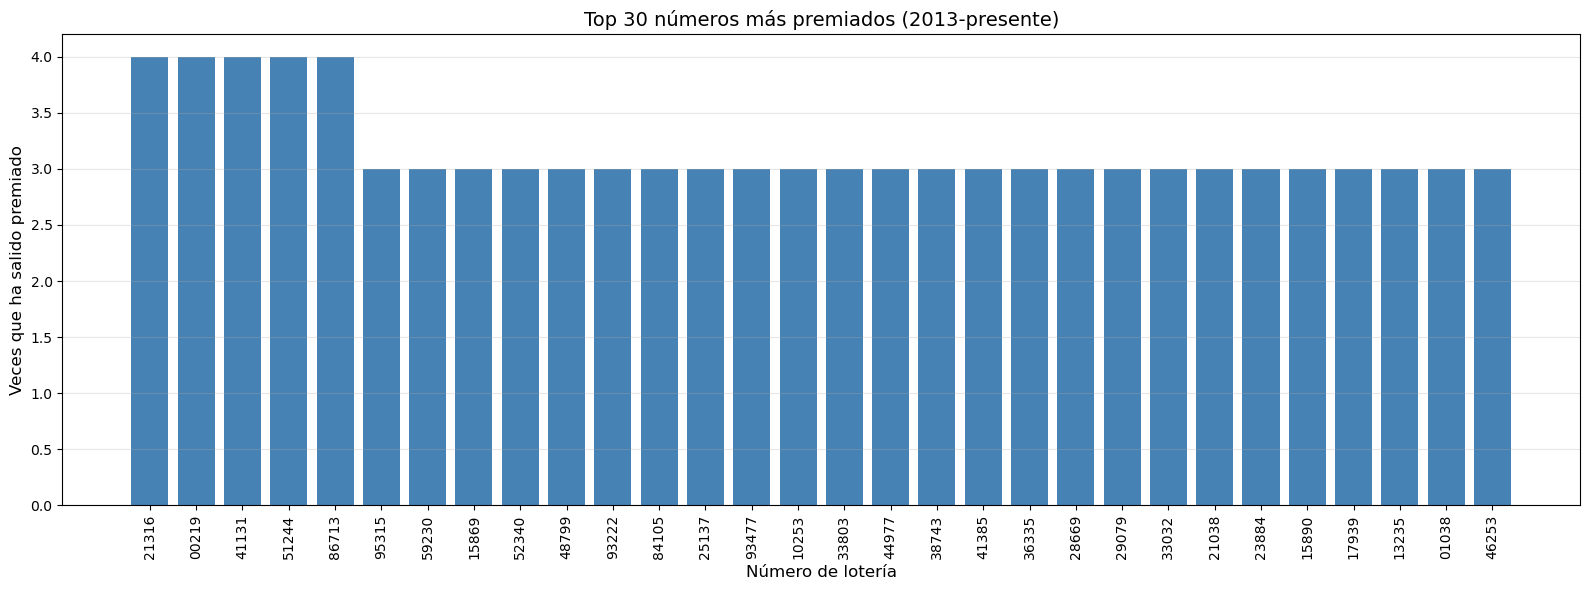

In [45]:
# Ver los números más repetidos
repeticiones = df['numero'].value_counts().sort_values(ascending=False)

print(f"Total de números únicos: {len(repeticiones)}")
print(f"Máximo de veces que se repite un número: {repeticiones.max()}")
print("\nTop 10 números más repetidos:")
print(repeticiones.head(10))

# Gráfico de los Top 30 más repetidos
plt.figure(figsize=(16, 6))
top_30 = repeticiones.head(30)
plt.bar(range(len(top_30)), top_30.values, color='steelblue')
plt.xticks(range(len(top_30)), top_30.index, rotation=90)
plt.xlabel('Número de lotería', fontsize=12)
plt.ylabel('Veces que ha salido premiado', fontsize=12)
plt.title('Top 30 números más premiados (2013-presente)', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

---

### 🏆 Análisis de los números **especiales** más repetidos

En este bloque se analiza **la frecuencia de aparición de los números del tipo “especial”** dentro del conjunto de datos, y se representa gráficamente el **Top 30 de los más premiados**.

<Figure size 1600x600 with 0 Axes>

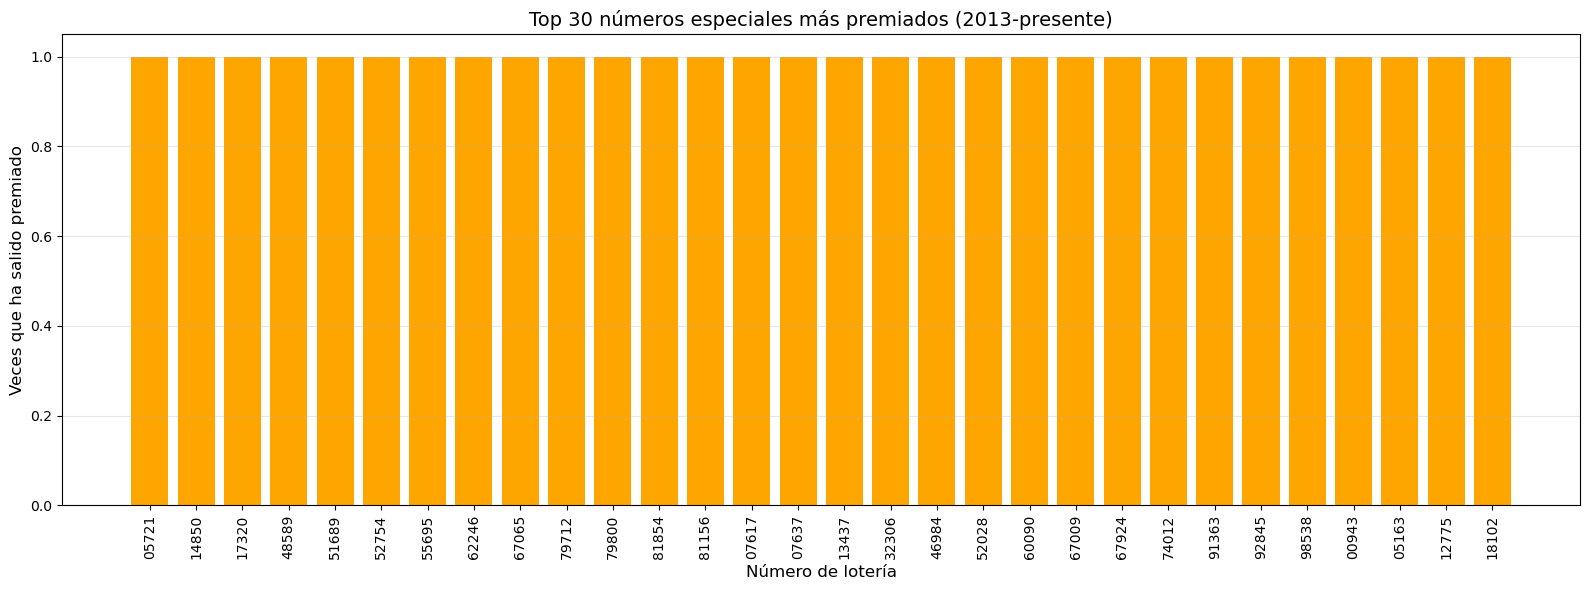

In [49]:
# Gráfico de los Top 30 números especiales más repetidos
df_especial = df[df['tipo'] == 'especial']
repeticiones_especial = df_especial['numero'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(16, 6))
top_30_especial = repeticiones_especial.head(30)
plt.bar(range(len(top_30_especial)), top_30_especial.values, color='orange')
plt.xticks(range(len(top_30_especial)), top_30_especial.index, rotation=90)
plt.xlabel('Número de lotería', fontsize=12)
plt.ylabel('Veces que ha salido premiado', fontsize=12)
plt.title('Top 30 números especiales más premiados (2013-presente)', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [54]:
# Crear columna de centenas (los primeros 3 dígitos de 'numero')
df['centena'] = df['numero'].str[2:6]

In [55]:
df

,anno,numero,premio,tipo,centena
0,2013,00020,1000,normal,020
1,2013,00219,1000,normal,219
2,2013,00324,1000,normal,324
3,2013,00330,1000,normal,330
4,2013,00461,1000,normal,461
...,...,...,...,...,...
21679,2024,99692,1000,normal,692
21680,2024,99710,1000,normal,710
21681,2024,99769,1000,normal,769
21682,2024,99864,1000,normal,864


---

### 🔢 Análisis de las **centenas más repetidas**

En este bloque se analiza la **frecuencia de las centenas** (los tres primeros dígitos de los números de lotería) para identificar cuáles aparecen con mayor recurrencia entre todos los números premiados.

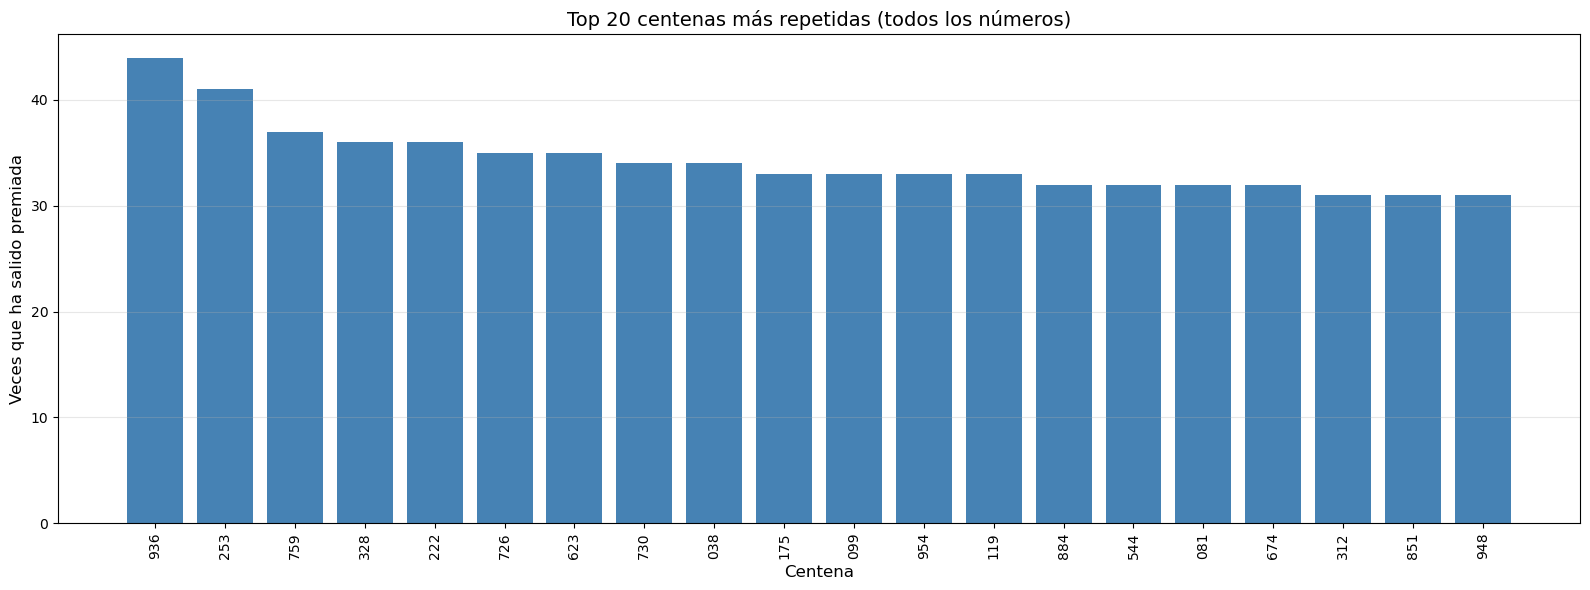

In [58]:
# Contar repeticiones de centenas para todos los números
repeticiones_centenas = df['centena'].value_counts().sort_values(ascending=False).head(20)

# --- Gráfico para las 20 centenas más repetidas (todos los números) ---
plt.figure(figsize=(16, 6))
plt.bar(range(len(repeticiones_centenas)), repeticiones_centenas.values, color='steelblue')
plt.xticks(range(len(repeticiones_centenas)), repeticiones_centenas.index, rotation=90)
plt.xlabel('Centena', fontsize=12)
plt.ylabel('Veces que ha salido premiada', fontsize=12)
plt.title('Top 20 centenas más repetidas (todos los números)', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

---

### 🟠 Análisis de las **centenas más repetidas en números especiales**

En este bloque se realiza un análisis similar al anterior, pero filtrando únicamente los **números de tipo “especial”**, con el fin de identificar las **centenas más frecuentes** dentro de este grupo particular.

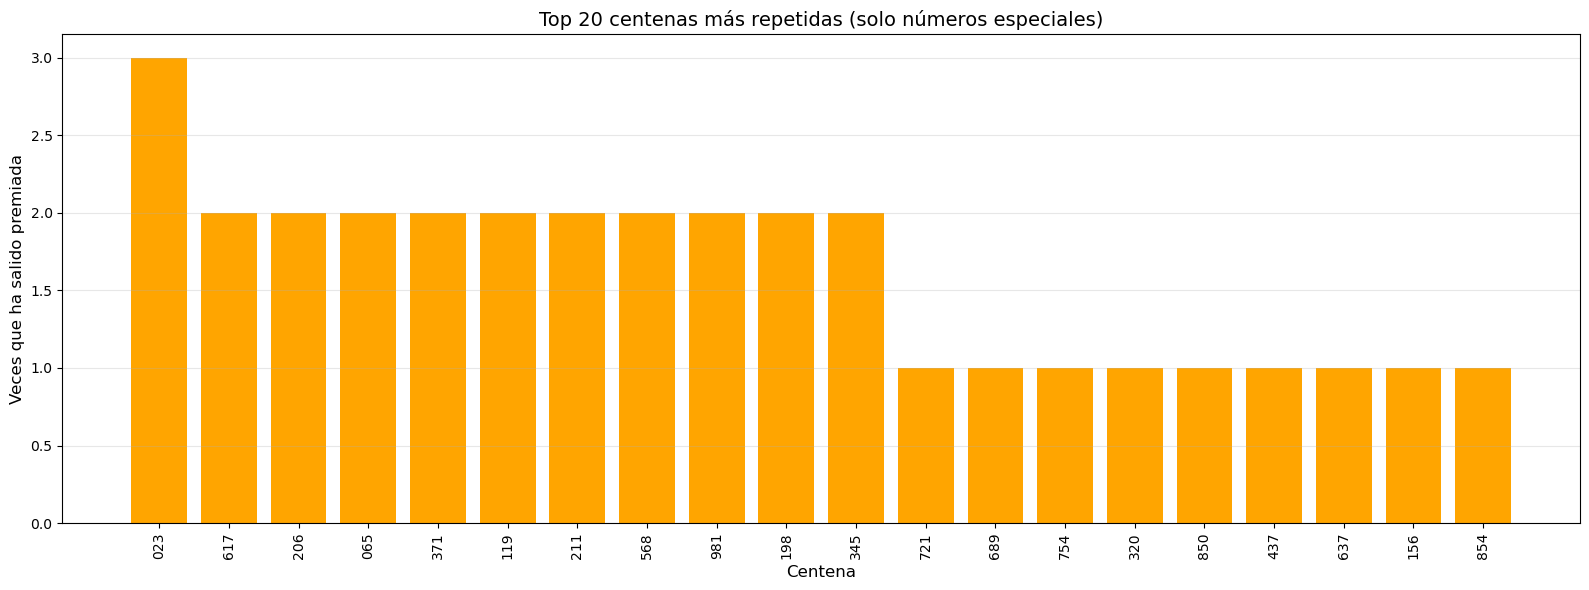

In [59]:
# Contar repeticiones de centenas solo para los especiales
df_especial = df[df['tipo'] == 'especial']
repeticiones_centenas_especial = df_especial['centena'].value_counts().sort_values(ascending=False).head(20)

# --- Gráfico para las 20 centenas más repetidas (solo especiales) ---
plt.figure(figsize=(16, 6))
plt.bar(range(len(repeticiones_centenas_especial)), repeticiones_centenas_especial.values, color='orange')
plt.xticks(range(len(repeticiones_centenas_especial)), repeticiones_centenas_especial.index, rotation=90)
plt.xlabel('Centena', fontsize=12)
plt.ylabel('Veces que ha salido premiada', fontsize=12)
plt.title('Top 20 centenas más repetidas (solo números especiales)', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

---

### 🔢 Análisis de la **frecuencia de dígitos por posición**

En este bloque se analiza la **distribución de los dígitos (0–9) en cada posición** de los números de lotería, con el fin de detectar patrones o sesgos en la aparición de ciertos dígitos según su posición.

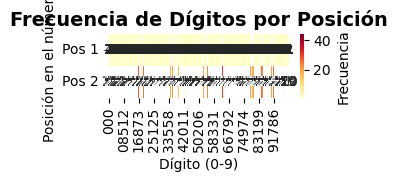

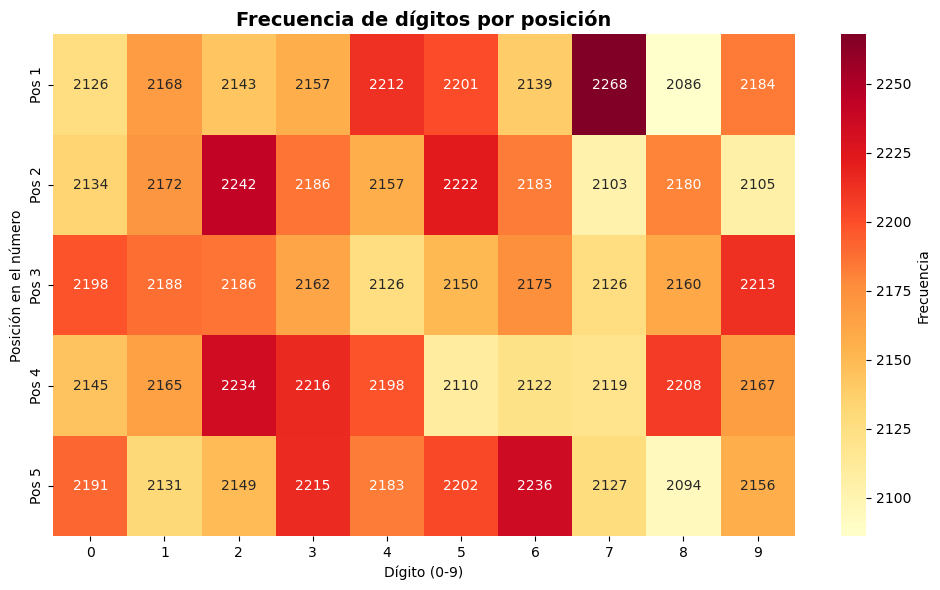

In [67]:
# Asegurarnos de que 'numero' tenga siempre 5 dígitos
df['numero_str'] = df['numero'].str.zfill(5)

# Crear un DataFrame con cada dígito en su columna
digitos = pd.DataFrame({
    'Pos 1': df['numero_str'].str[0],
    'Pos 2': df['numero_str'].str[1],
    'Pos 3': df['numero_str'].str[2],
    'Pos 4': df['numero_str'].str[3],
    'Pos 5': df['numero_str'].str[4]
})

# Contar frecuencia de cada dígito (0-9) en cada posición
frecuencia = digitos.apply(lambda col: col.value_counts().sort_index()).fillna(0)

# Graficar heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(frecuencia.T, annot=True, fmt='g', cmap='YlOrRd', cbar_kws={'label': 'Frecuencia'})
plt.title('Frecuencia de dígitos por posición', fontsize=14, fontweight='bold')
plt.xlabel('Dígito (0-9)')
plt.ylabel('Posición en el número')
plt.tight_layout()
plt.show()

---

### 💾 Guardado del DataFrame procesado

En este paso final se **guardan los datos ya procesados** para poder reutilizarlos en futuros análisis sin tener que ejecutar nuevamente todas las etapas de limpieza y transformación.

In [72]:
# Guardar el DataFrame procesado
df.to_csv('loteria_datos.csv', index=False)
# Guardar el DataFrame procesado en formato pickle (rápido y conserva tipos de datos)
df.to_pickle('loteria_datos.pkl')

print("Datos guardados correctamente")

Datos guardados correctamente
